# Empirical Relation Between Seismic Observable and Sediment Thickness

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns
import numpy as np
from numpy.polynomial import Polynomial
from scipy import stats
import os
import geopandas as gpd

from utils import get_australian_sedimentary_basins, get_geological_timeline

Load the seismic measurements and sediment thicknesses estimated from boreholes

In [2]:
dataroot = os.path.join("..", "data", "processed")
run = max(
    [
        os.path.join(dataroot, d)
        for d in os.listdir(dataroot)
        if os.path.isdir(os.path.join(dataroot, d))
    ],
    key=os.path.getmtime,
)
seismics = gpd.read_file(os.path.join(run, "dataframe.json"))

In [3]:
seismics.head()

,stations,delays,traveltimes,borehole_count,closest_borehole_distance,MAX_DEPTH,MEAN_DEPTH,IDW_MEAN_DEPTH,CLOSEST_DEPTH,geometry
0,OA.BM31,0.0,NaN,0,126.423507,NaN,NaN,NaN,NaN,POINT (129.99306 -22.99594)
1,OA.BN29,0.0,NaN,0,64.870482,NaN,NaN,NaN,NaN,POINT (130.49642 -22.00640)
2,OA.BO24,0.0,NaN,0,236.959930,NaN,NaN,NaN,NaN,POINT (130.99715 -19.50722)
3,OA.BV23,0.0,NaN,0,71.116199,NaN,NaN,NaN,NaN,POINT (134.47980 -19.01860)
4,OA.BV30,0.0,NaN,0,63.231991,NaN,NaN,NaN,NaN,POINT (134.46200 -22.49400)


In [4]:
depth_estimates = seismics[
    ["MAX_DEPTH", "MEAN_DEPTH", "IDW_MEAN_DEPTH", "CLOSEST_DEPTH", "geometry"]
]

Scatter $T_{PS_b}$ vs depth

Text(0.5, 0, 'Delay Time (s)')

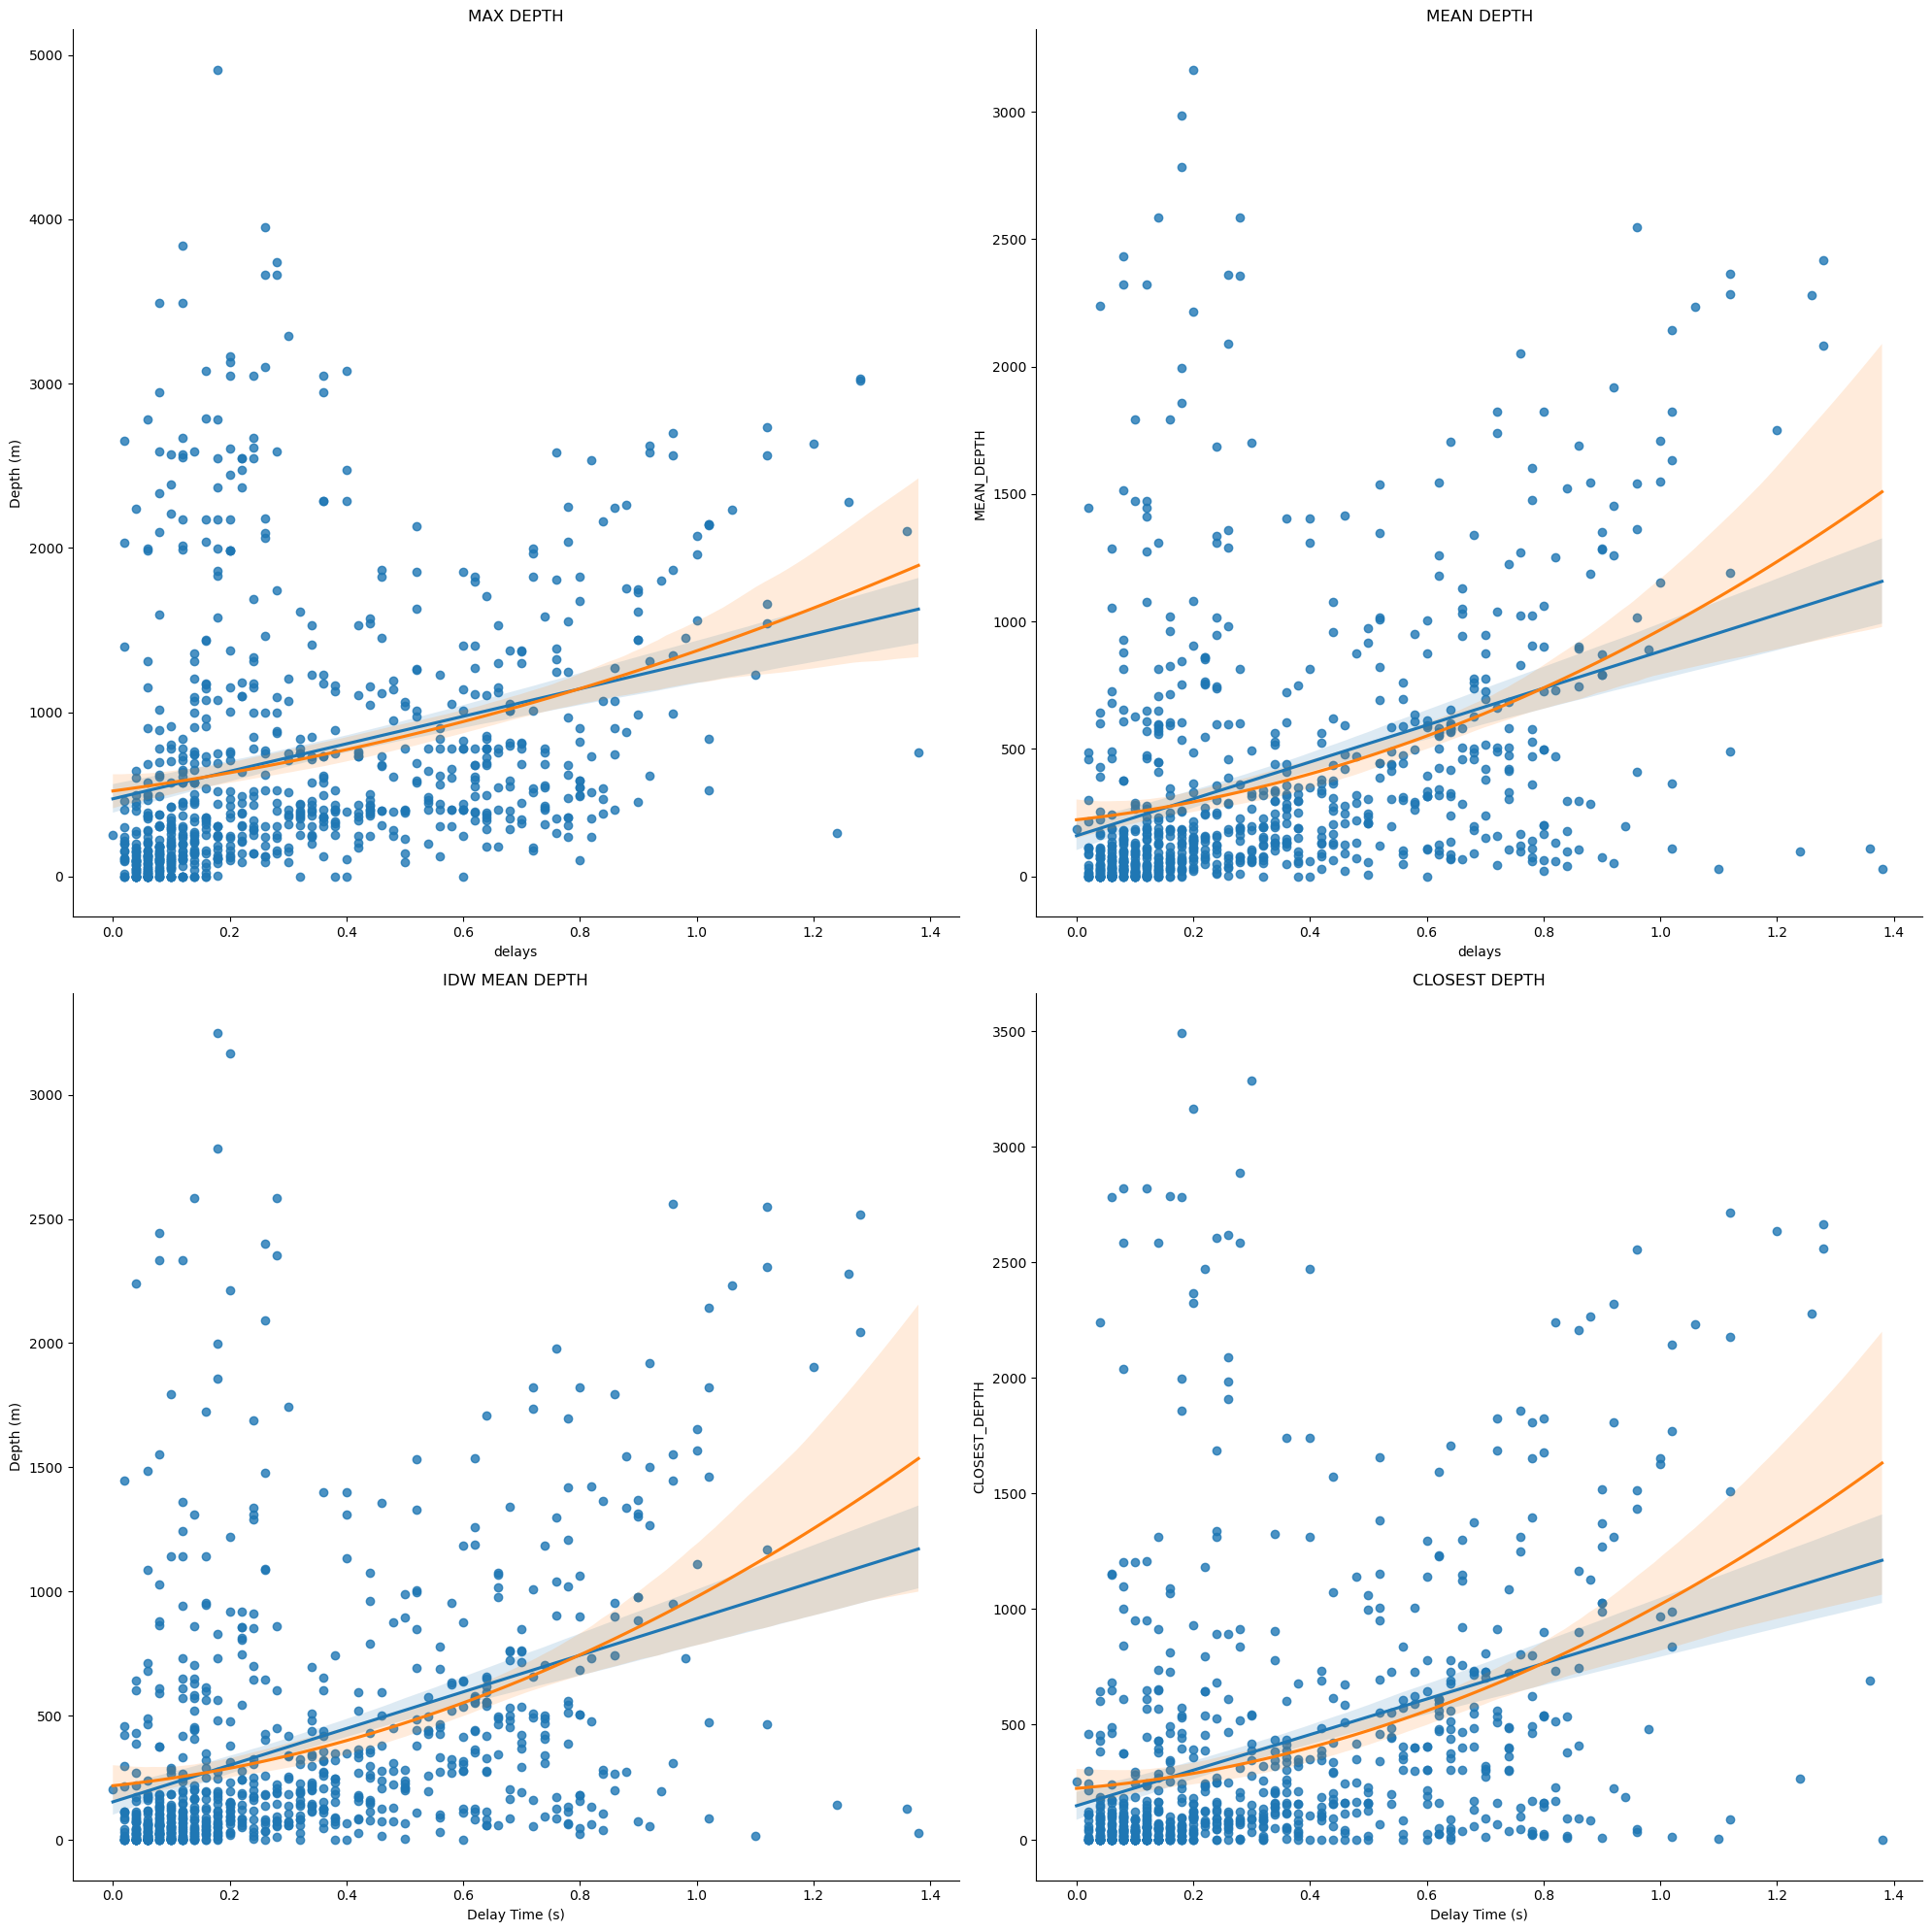

In [5]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(20, 20),
    tight_layout=True,
)
for ax, depth in zip(
    axs.flatten(), depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns
):
    sns.regplot(seismics, x="delays", y=depth, ax=ax)
    sns.regplot(seismics, x="delays", y=depth, ax=ax, order=2, scatter=False)
    ax.set_title(depth.replace("_", " "))
    ax.spines[["top", "right"]].set_visible(False)

axs[0, 0].set_ylabel("Depth (m)")
axs[1, 0].set_ylabel("Depth (m)")
axs[1, 0].set_xlabel("Delay Time (s)")
axs[1, 1].set_xlabel("Delay Time (s)")

Bin the delay times

In [6]:
def slope_ci(x, y, yfit, q=0.975):
    """
    Grabbed from https://nbviewer.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    x: independent variable locations
    y: dependent variabl observations
    yfit: dependent variable predictions from linear regression
    q: percentile e.g. q=0.975 will give the 95% two-tailed CI
    """
    n = y.size
    residuals = y - yfit
    s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
    t = stats.t.ppf(0.975, n - 2) 
    ci = t * s_err * np.sqrt(    1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    return ci

Text(0.5, 0, '$T_{PS_{b}}$ (s)')

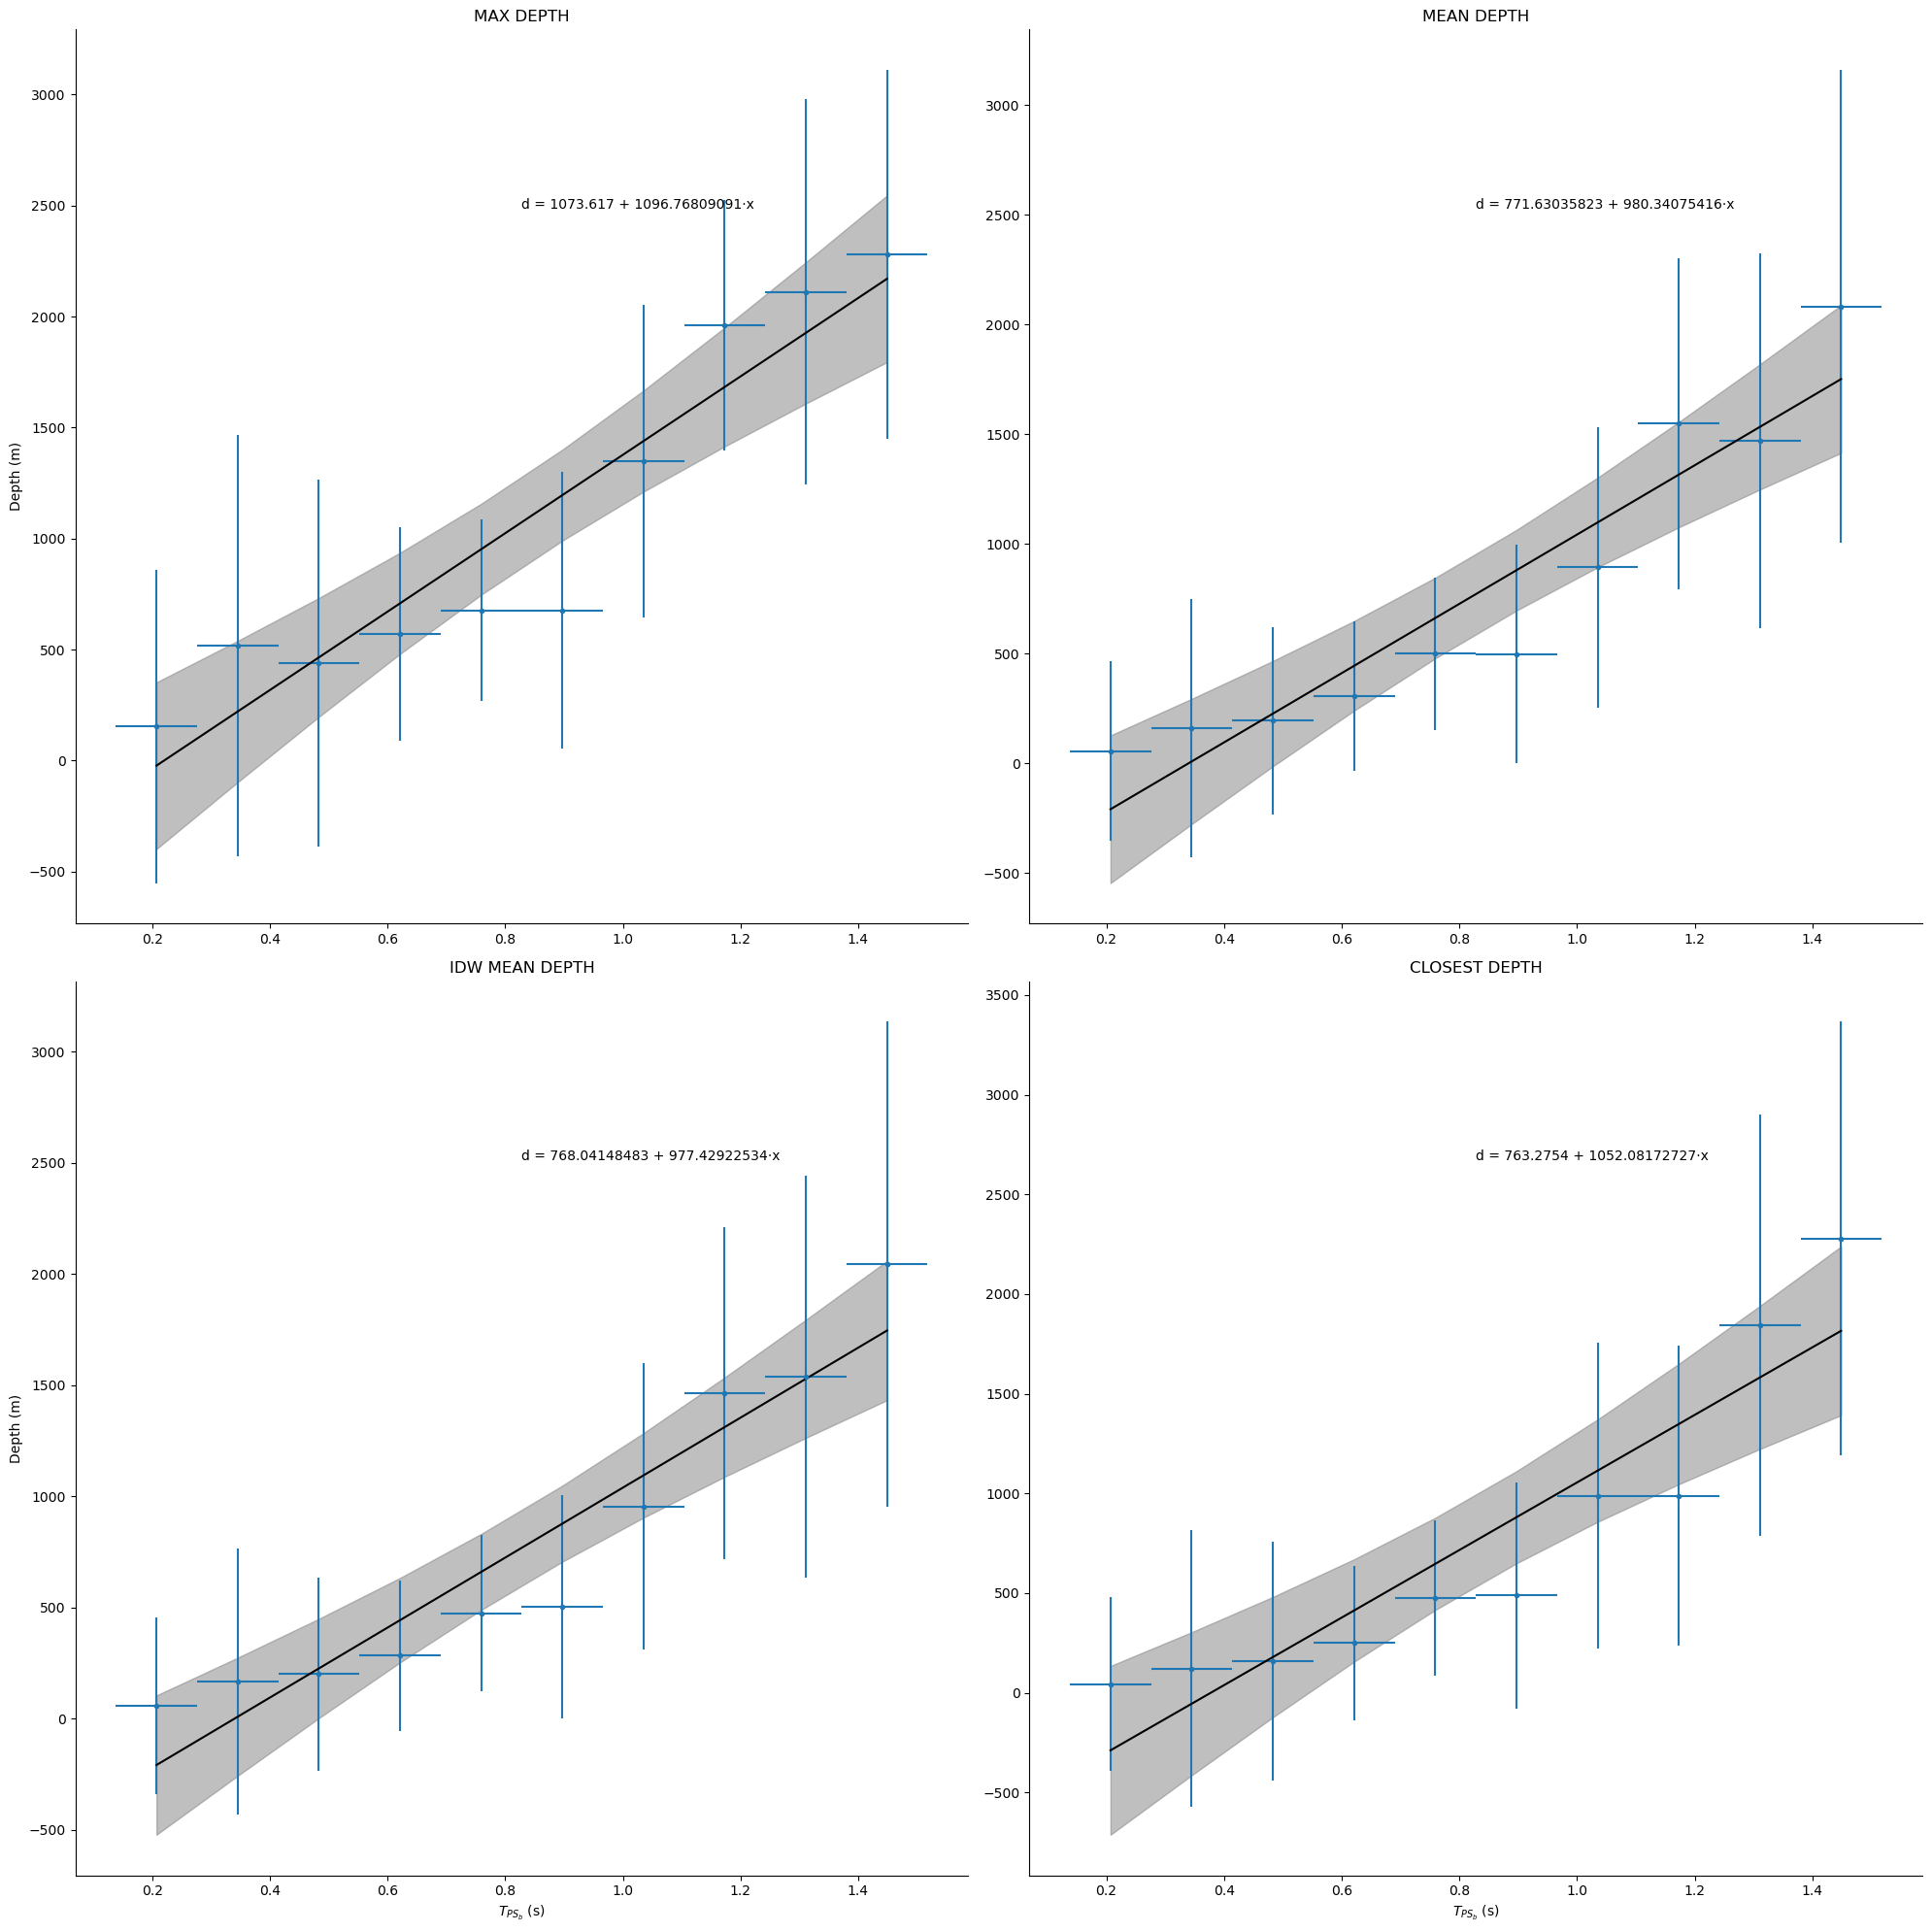

In [7]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(20, 20),
    tight_layout=True,
)
for ax, depth in zip(
    axs.flatten(), depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns
):
    ax.set_title(depth.replace("_", " "))
    ax.spines[["top", "right"]].set_visible(False)

    x = seismics.delays
    y = seismics[depth]
    idx = np.isfinite(x) & np.isfinite(y)
    x = x.loc[idx]
    y = y.loc[idx]

    bin_vals, bin_edges, binnumber = stats.binned_statistic(x, y, statistic="median")
    bin_stds, _, _ = stats.binned_statistic(x, y, statistic="std")

    # empty bins return NaN so drop these
    idx = ~np.isfinite(bin_vals)
    bin_vals = np.delete(bin_vals, idx)
    bin_stds = np.delete(bin_stds, idx)

    x = bin_edges[1:] + (bin_edges[1:] - bin_edges[:-1]) / 2  # bin midpoints
    x =  np.delete(x, idx)
    x_err = (bin_edges[1] - bin_edges[0]) / 2
    y = bin_vals
    y_err = bin_stds
    p = Polynomial.fit(x, y, deg=1)
    yfit = p(x)
    ci = slope_ci(x, y, yfit)
    ax.errorbar(x, y, y_err, x_err, fmt=".")
    ax.plot(x, yfit, color="k")
    ax.fill_between(x, yfit+ci, yfit-ci, color="grey", alpha=0.5)

    ax.text(0.5, 0.8, transform=ax.transAxes, s=f"d = {str(p)}")

axs[0, 0].set_ylabel("Depth (m)")
axs[1, 0].set_ylabel("Depth (m)")
axs[1, 0].set_xlabel("$T_{PS_{b}}$ (s)")
axs[1, 1].set_xlabel("$T_{PS_{b}}$ (s)")


Break units up by sedimentary basin age

In [8]:
basins = get_australian_sedimentary_basins()
station_age = []
timeline = get_geological_timeline()
station_era = []
for point in seismics.geometry:
    contains = basins.contains(point)
    if contains.any():
        _basins = basins[contains]
        oldest = _basins["period_age"].idxmax()
        _period = _basins.loc[oldest]["period"]
        station_age.append(_period)
        station_era.append(_period if _period == "Precambrian" else timeline[_period]["parent"][0])
    else:
        station_age.append(None)
        station_era.append(None)
seismics["BasinPeriod"] = station_age
seismics["BasinEra"] = station_era

Create colour palette based on geological timeline

In [9]:
palette = {}
with open(os.path.join("..", "data", "geological_timescale", "geological_timeline.cpt"), "r") as f:
    lines = f.readlines()
    hue_order = [line.split(";")[-1][1:-1] for line in lines]  # [1:-1] trims leading space and newline character
    _colours = [line.split()[1:4] for line in lines]

    for p, c in zip(hue_order, _colours):
        palette[p] = [int(_c) / 255 for _c in c] + [1]  # [1] is alpha channel
    hue_order.append("Precambrian")
    palette["Precambrian"] = [i for i in to_rgb("#80808080")]

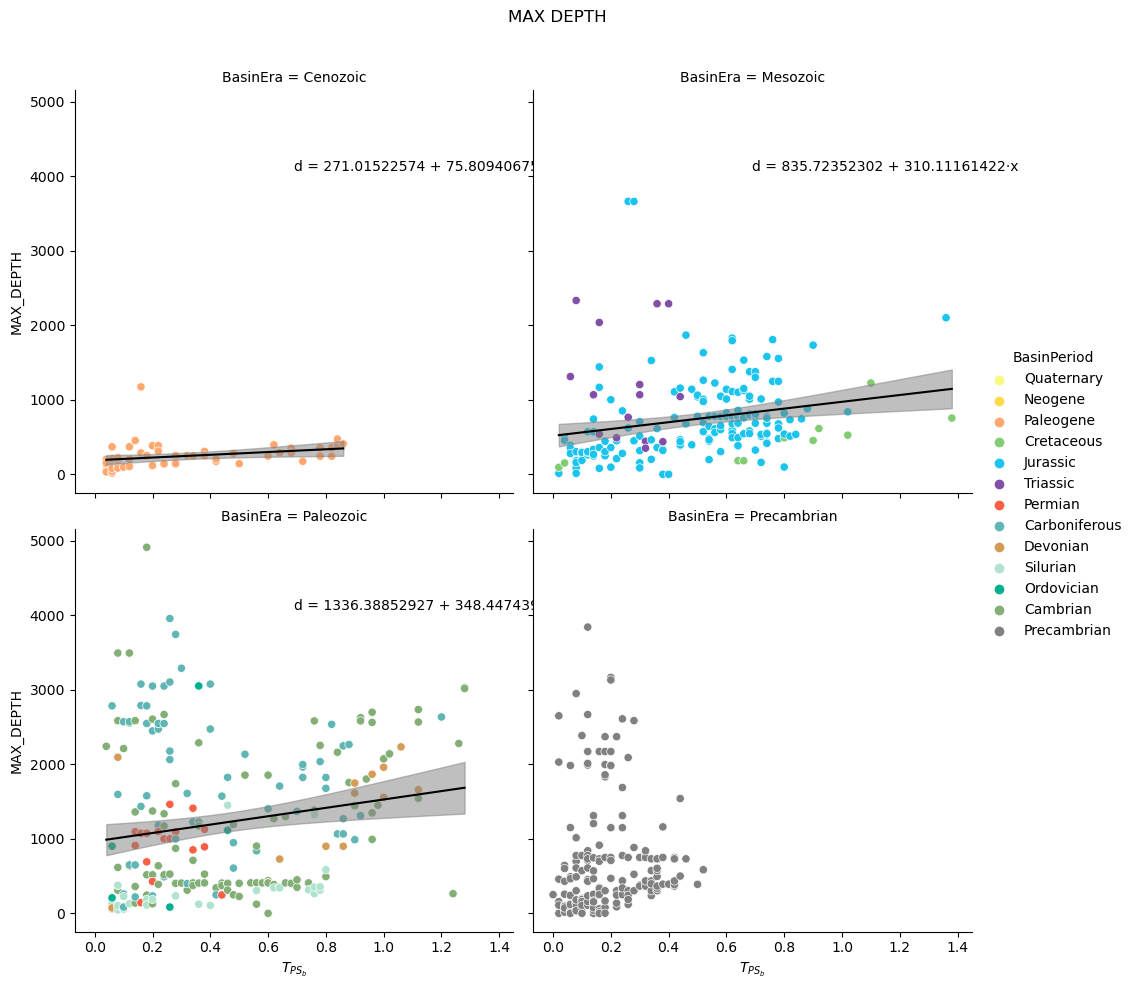

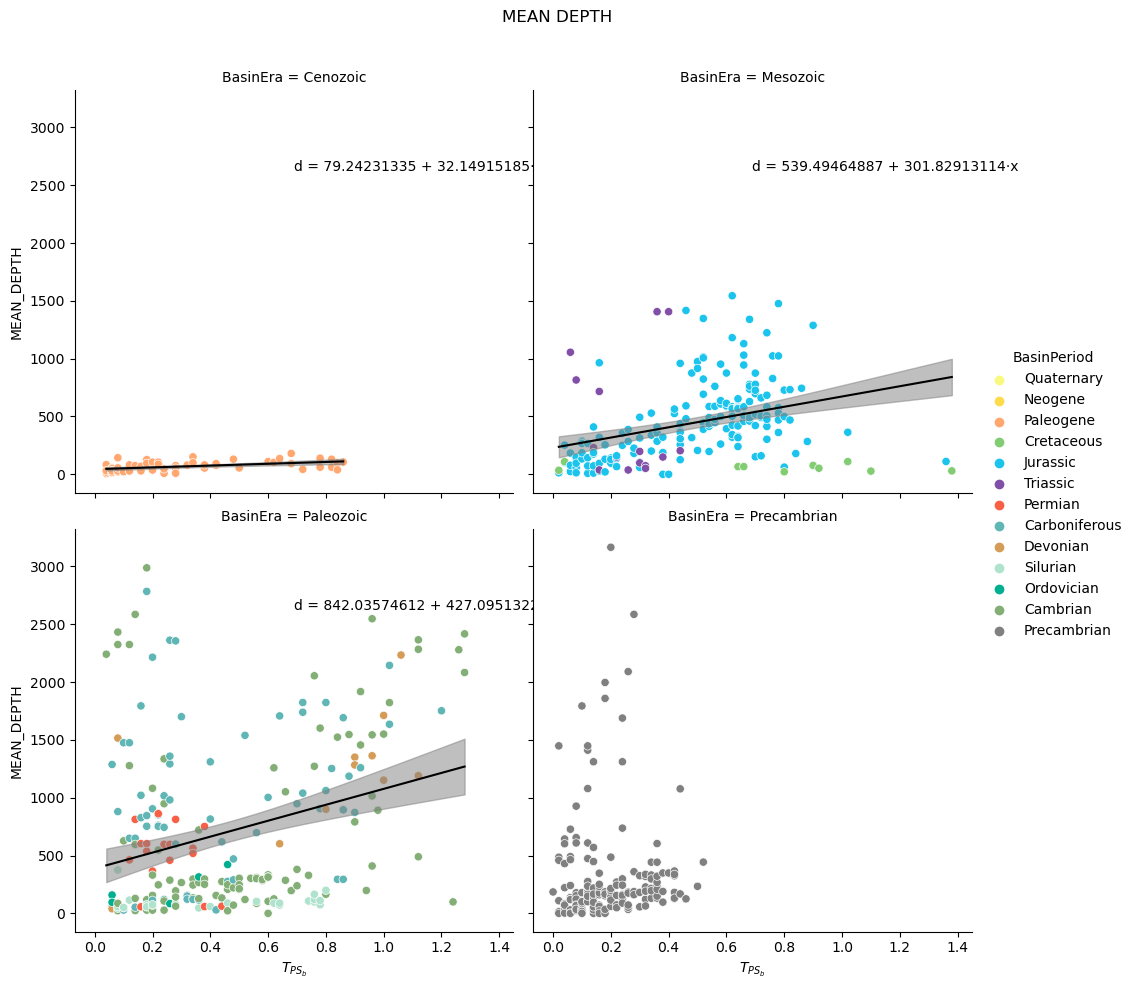

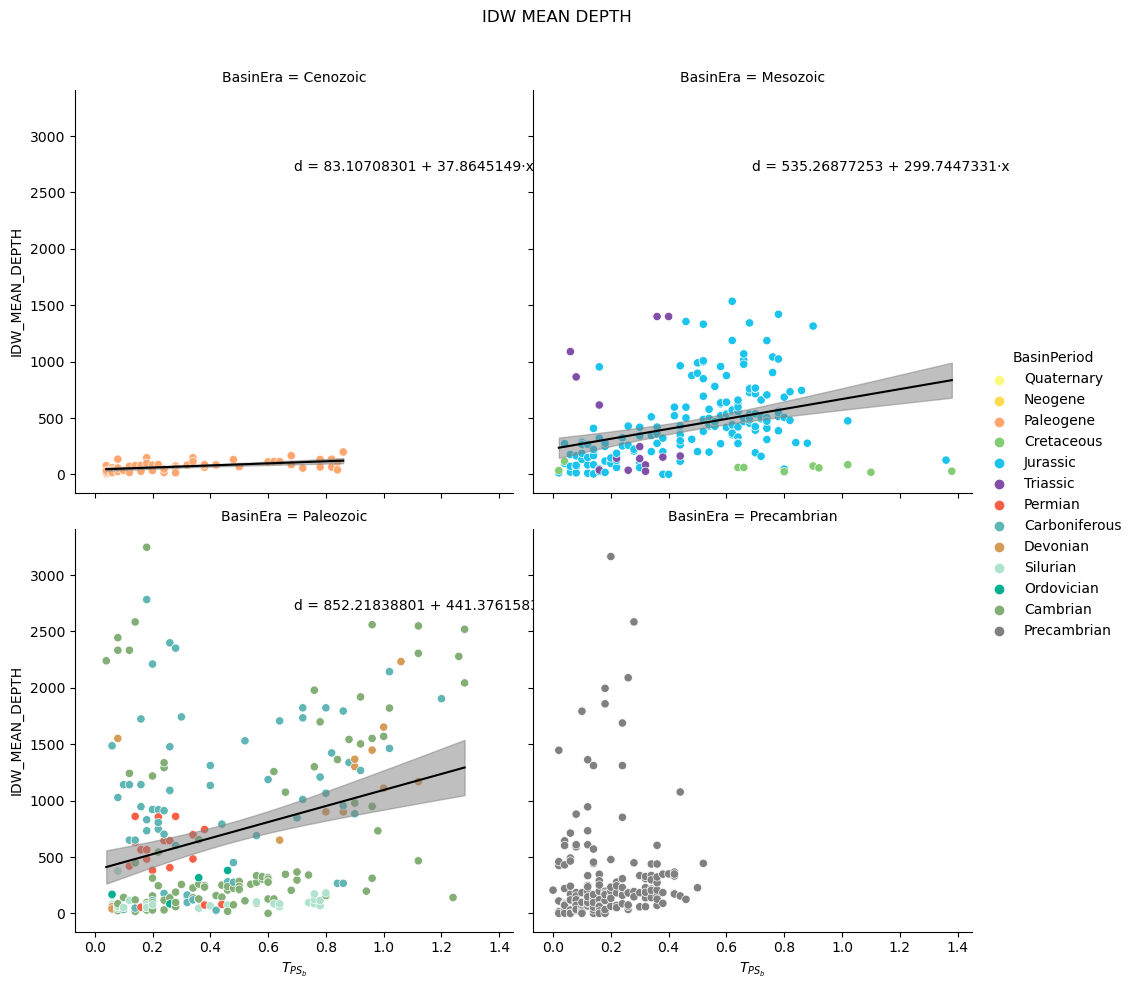

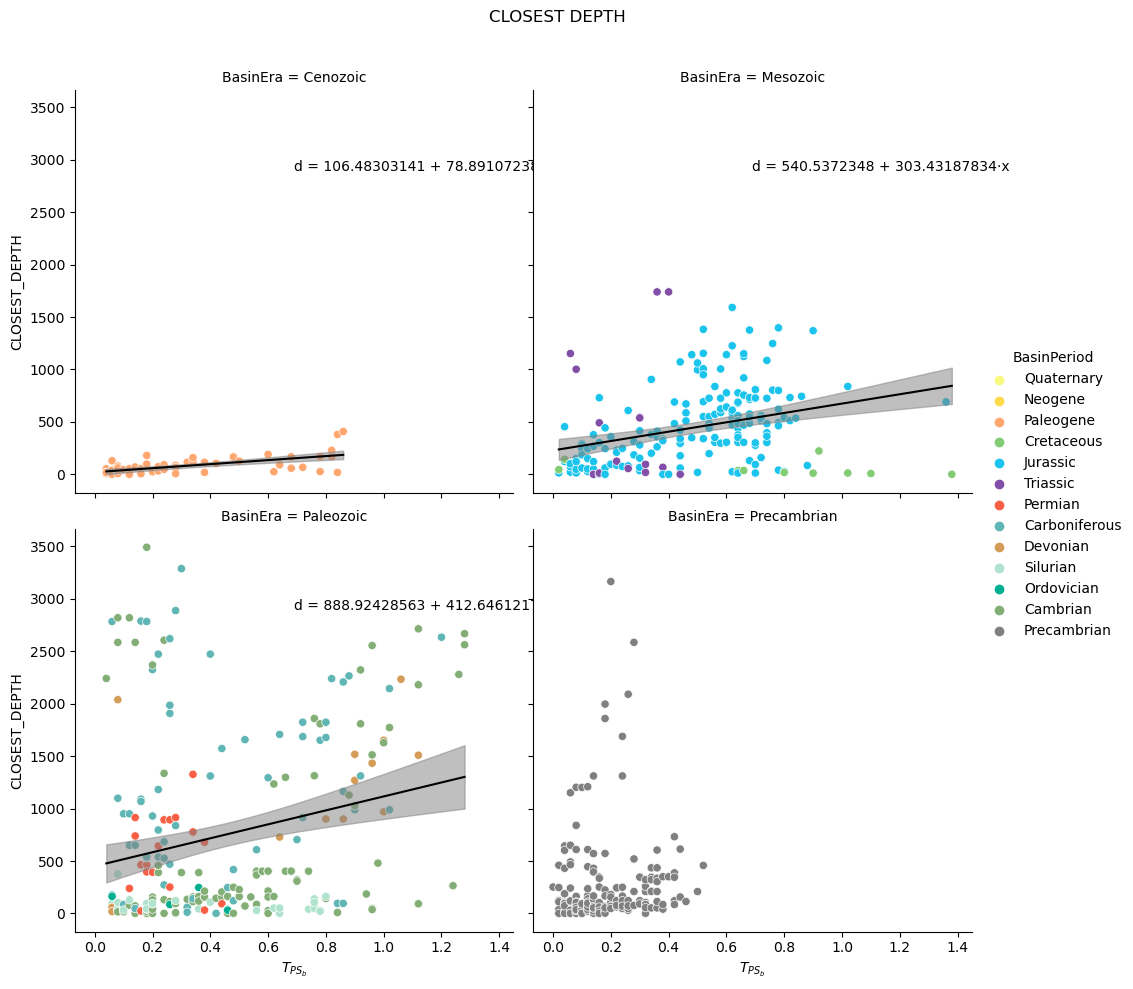

In [10]:
eras = ["Cenozoic", "Mesozoic", "Paleozoic", "Precambrian"]
for depth in depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns:
    g = sns.relplot(
        data=seismics,
        x="delays",
        y=depth,
        hue="BasinPeriod",
        hue_order=hue_order,
        col="BasinEra",
        palette=palette,
        col_order=eras,
        col_wrap=2,
    )

    for era in eras[:-1]:  # don't fit Precambrian
        _stations = seismics.loc[seismics["BasinEra"] == era]
        x = _stations.delays
        y = _stations[depth]
        idx = np.isfinite(x) & np.isfinite(y)
        p = Polynomial.fit(x.loc[idx], y.loc[idx], deg=1)
        yfit = p(x.loc[idx])
        ci = slope_ci(x.loc[idx], y.loc[idx], yfit)
        g.axes_dict[era].plot(x.loc[idx], yfit, color="k")
        g.axes_dict[era].fill_between(x.loc[idx], yfit+ci, yfit-ci, color="grey", alpha=0.5)

        g.axes_dict[era].text(0.5, 0.8, transform=g.axes_dict[era].transAxes, s=f"d = {str(p)}")

    g.axes[2].set_xlabel("$T_{PS_{b}}$")
    g.axes[3].set_xlabel("$T_{PS_{b}}$")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(depth.replace("_", " "))




Bin the measurements and ignore Precambrian

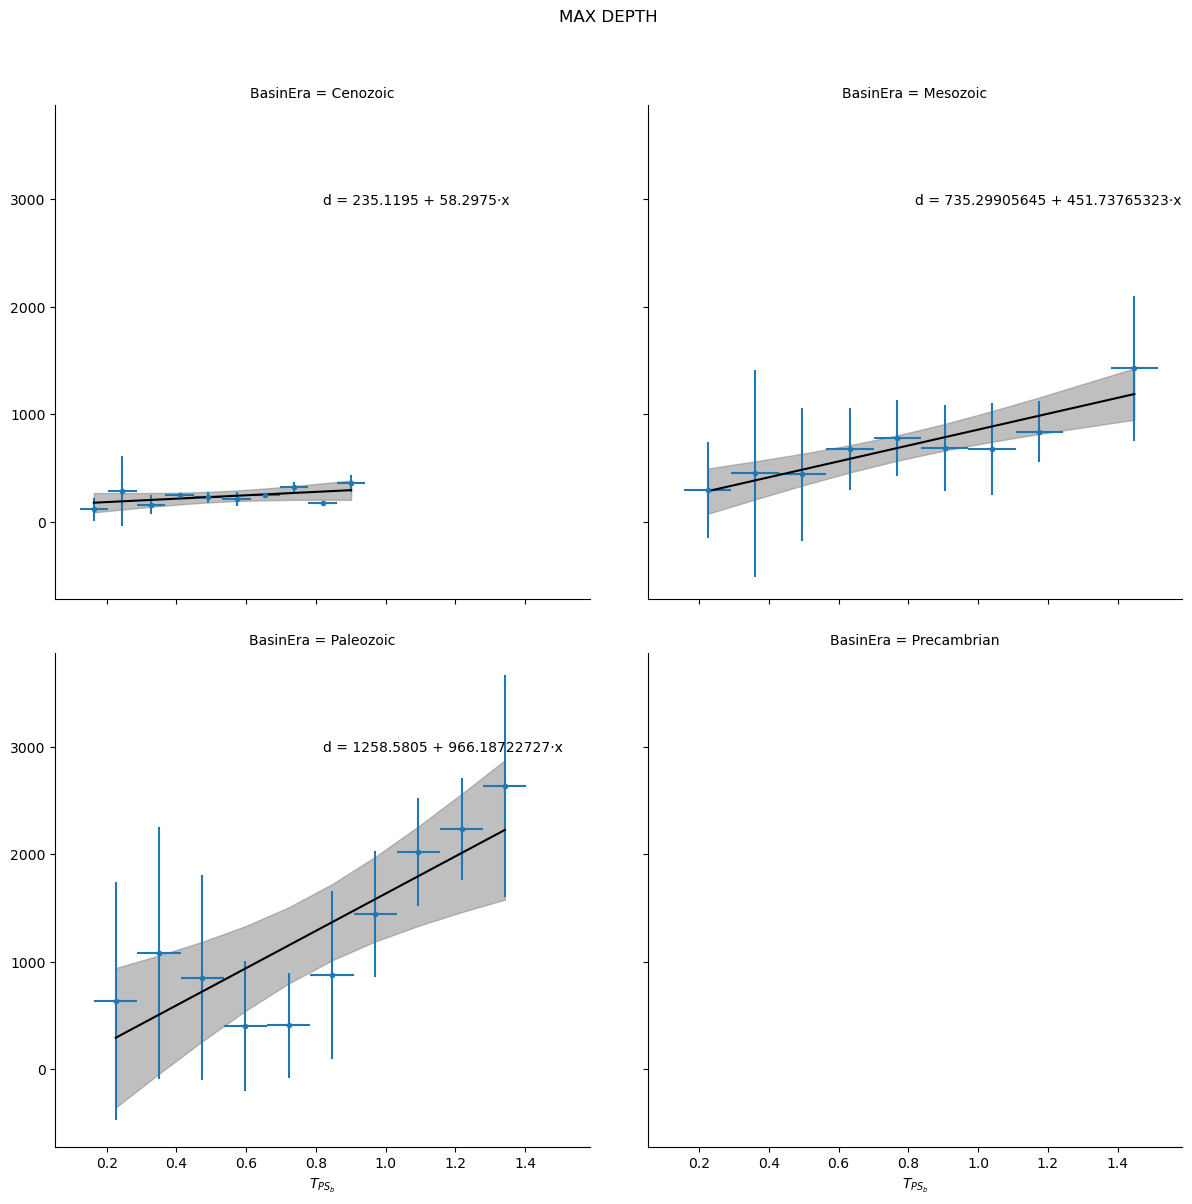

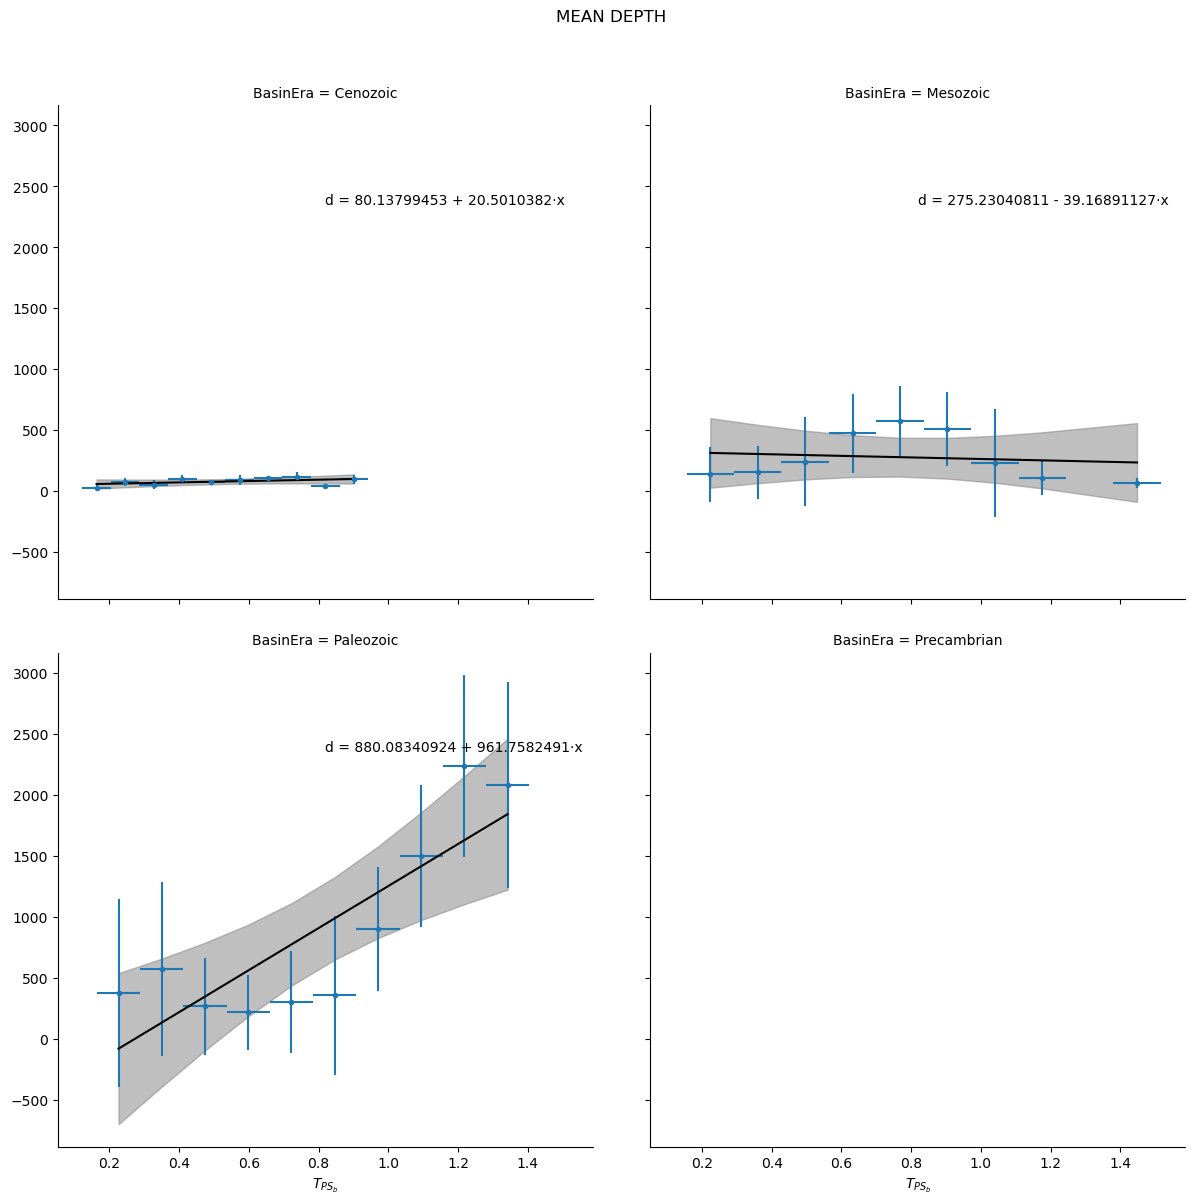

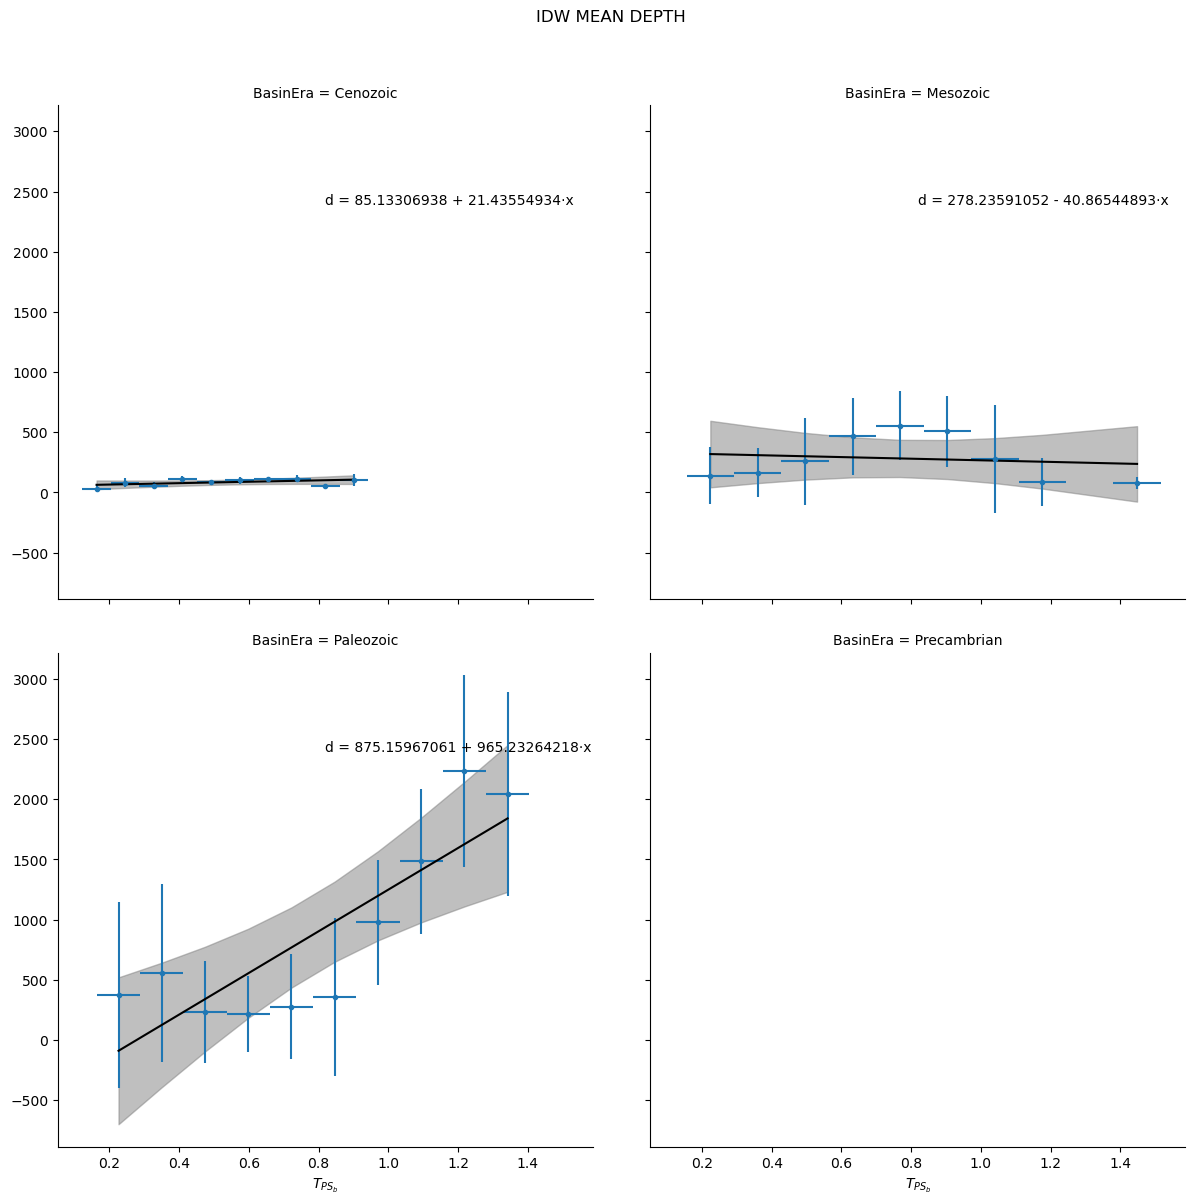

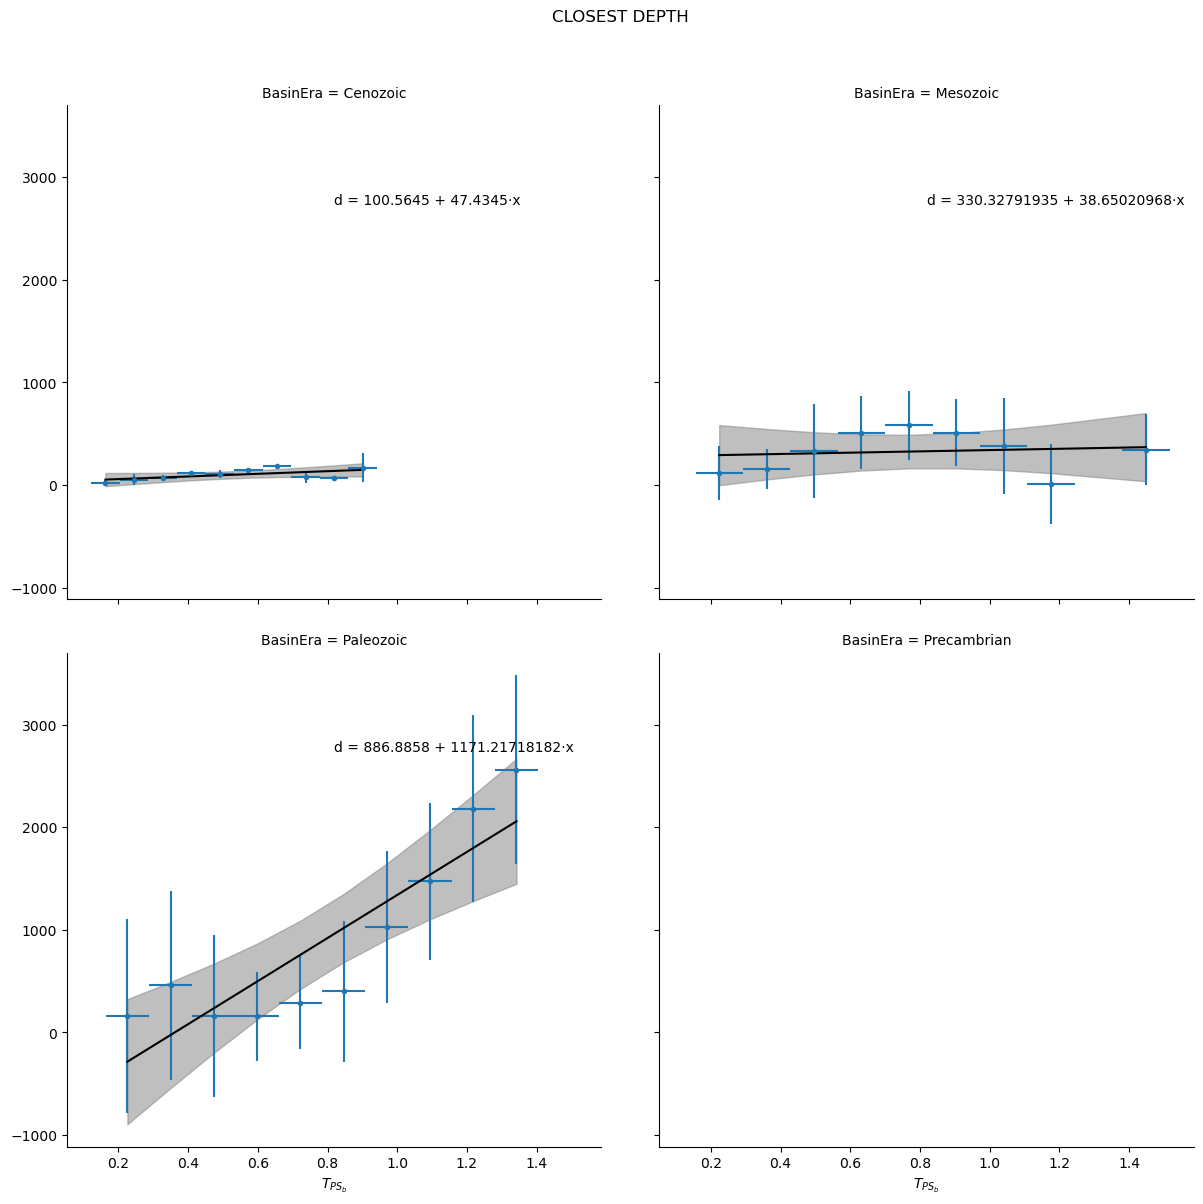

In [11]:
for depth in depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns:
    g = sns.FacetGrid(
        data=seismics,
        col="BasinEra",
        col_order=eras,
        col_wrap=2,
        height=6
    )

    for era in eras[:-1]:  # don't fit Precambrian
        _stations = seismics.loc[seismics["BasinEra"] == era]
        x = _stations.delays
        y = _stations[depth]
        idx = np.isfinite(x) & np.isfinite(y)
        x = x.loc[idx]
        y = y.loc[idx]

        bin_vals, bin_edges, binnumber = stats.binned_statistic(x, y, statistic="median")
        bin_stds, _, _ = stats.binned_statistic(x, y, statistic="std")

        # empty bins return NaN so drop these
        idx = ~np.isfinite(bin_vals)
        bin_vals = np.delete(bin_vals, idx)
        bin_stds = np.delete(bin_stds, idx)

        x = bin_edges[1:] + (bin_edges[1:] - bin_edges[:-1]) / 2  # bin midpoints
        x =  np.delete(x, idx)
        x_err = (bin_edges[1] - bin_edges[0]) / 2
        y = bin_vals
        y_err = bin_stds
        p = Polynomial.fit(x, y, deg=1)
        yfit = p(x)
        ci = slope_ci(x, y, yfit)
        g.axes_dict[era].errorbar(x, y, y_err, x_err, fmt=".")
        g.axes_dict[era].plot(x, yfit, color="k")
        g.axes_dict[era].fill_between(x, yfit+ci, yfit-ci, color="grey", alpha=0.5)

        g.axes_dict[era].text(0.5, 0.8, transform=g.axes_dict[era].transAxes, s=f"d = {str(p)}")

    g.axes[2].set_xlabel("$T_{PS_{b}}$")
    g.axes[3].set_xlabel("$T_{PS_{b}}$")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(depth.replace("_", " "))

Inverse error weighting

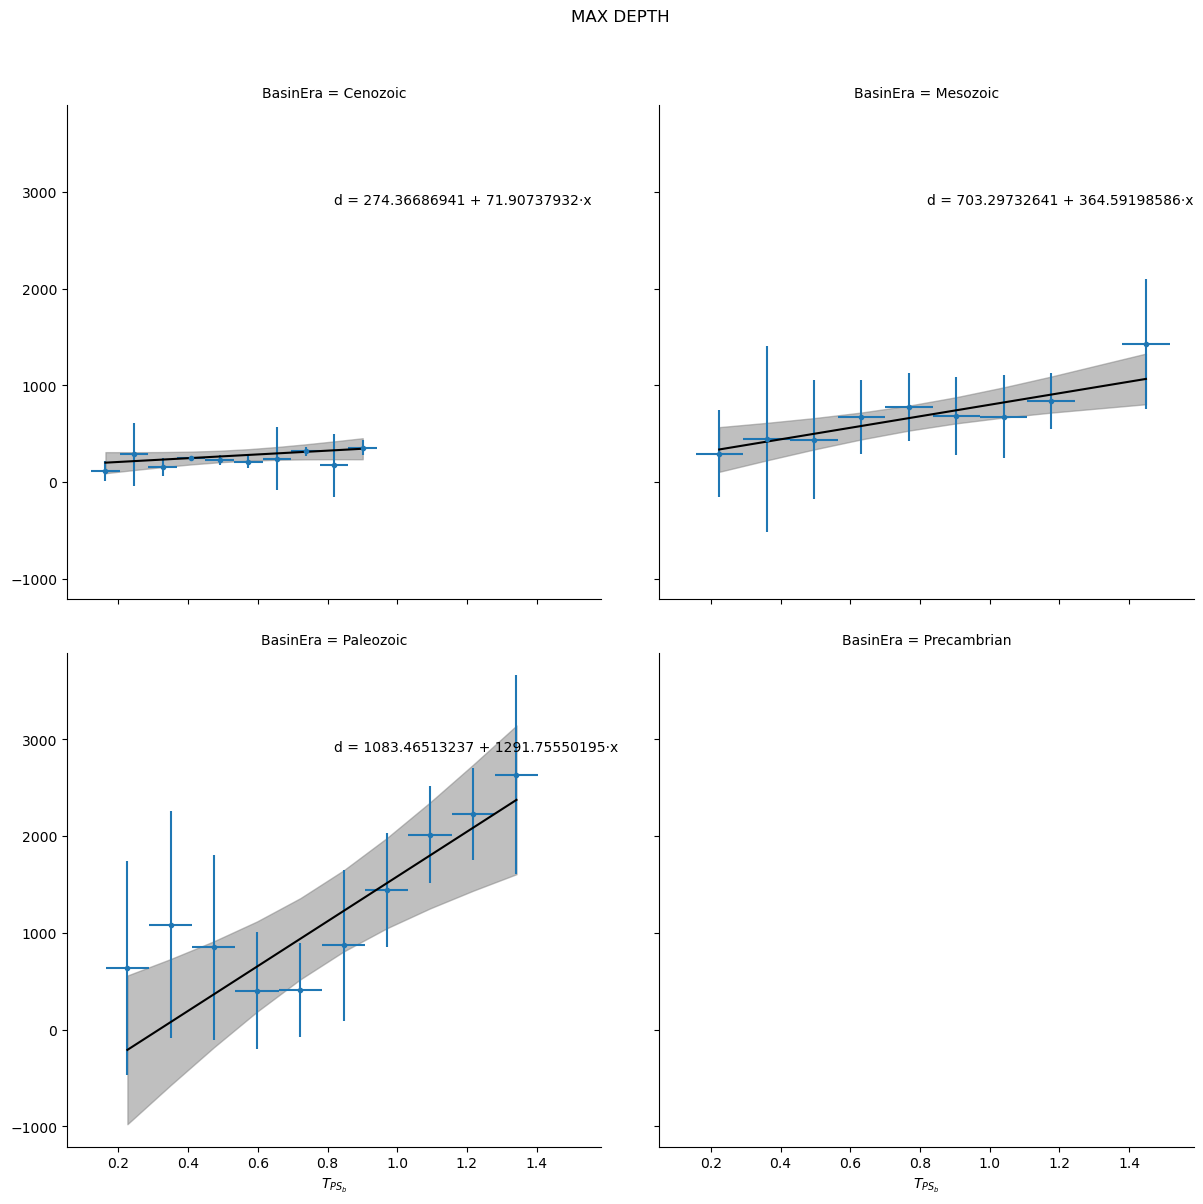

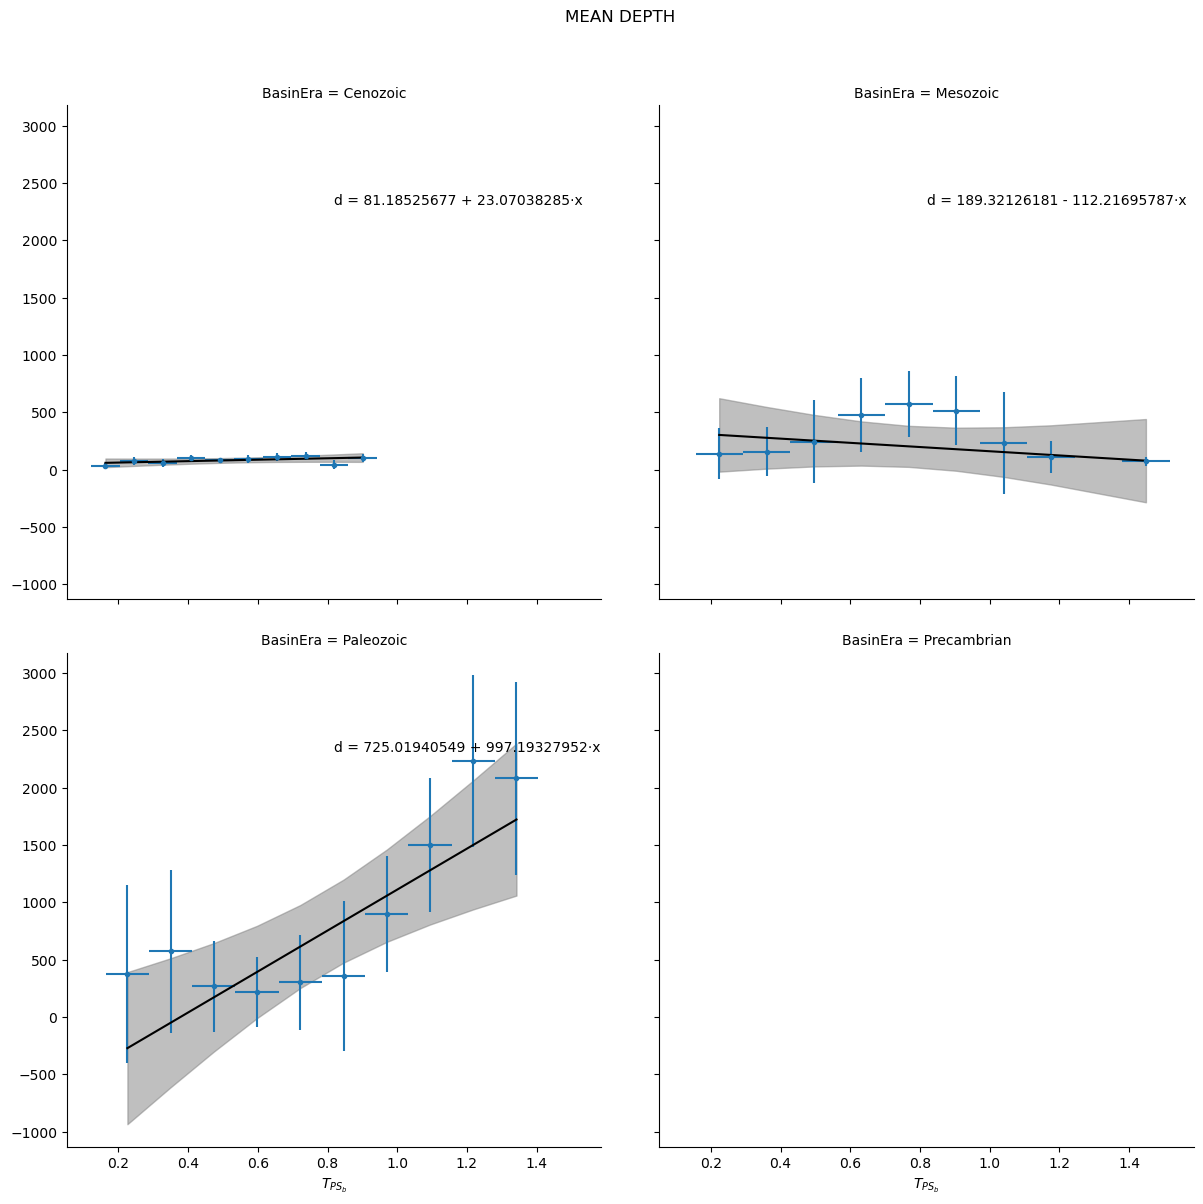

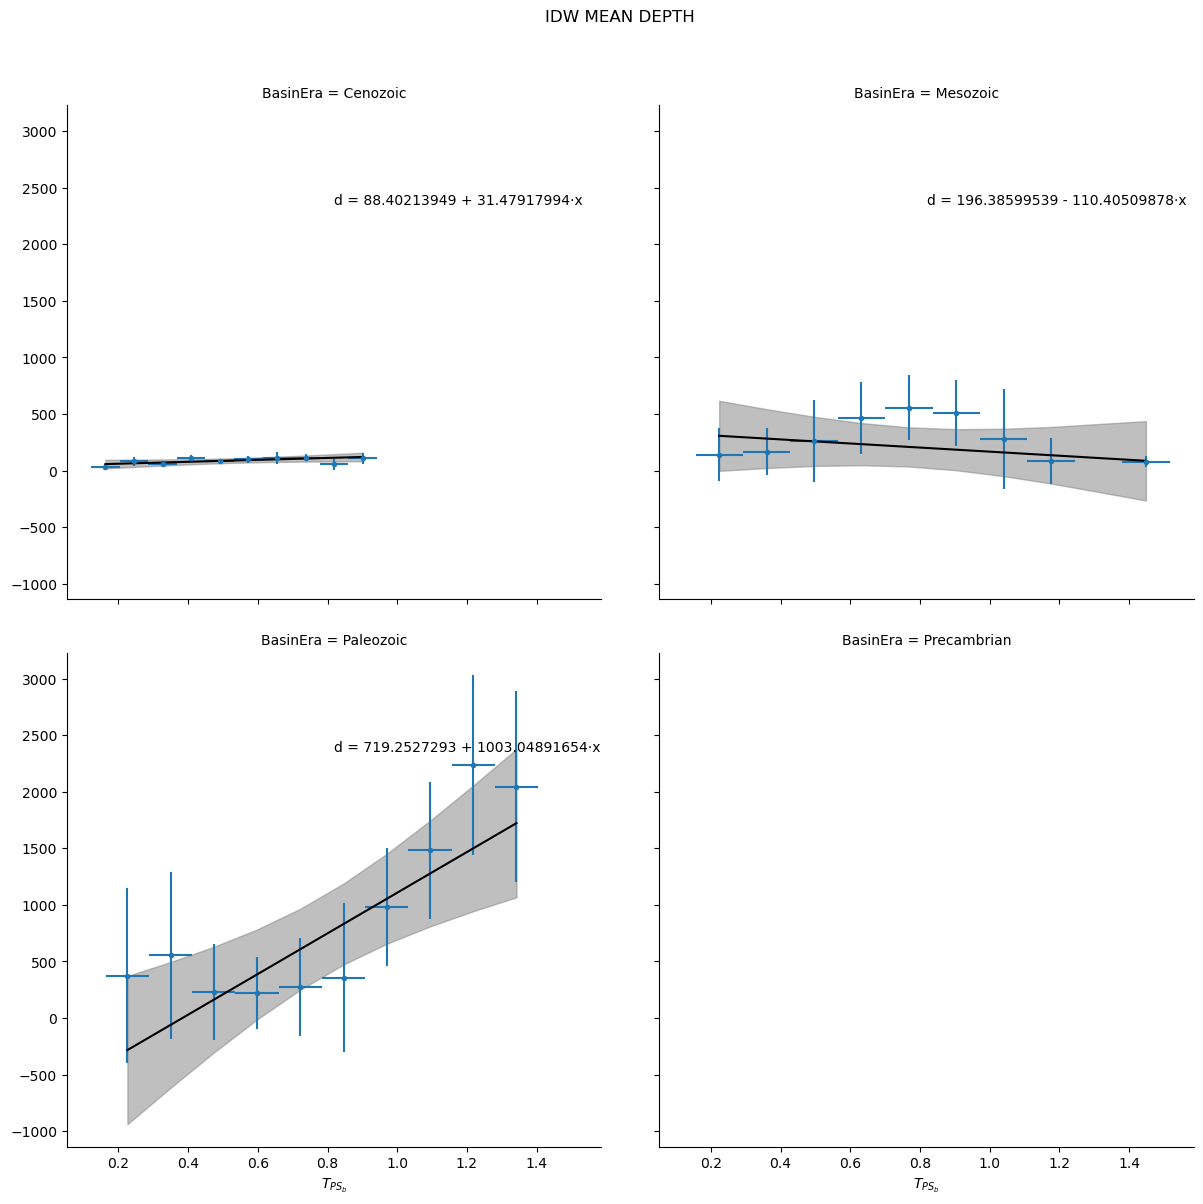

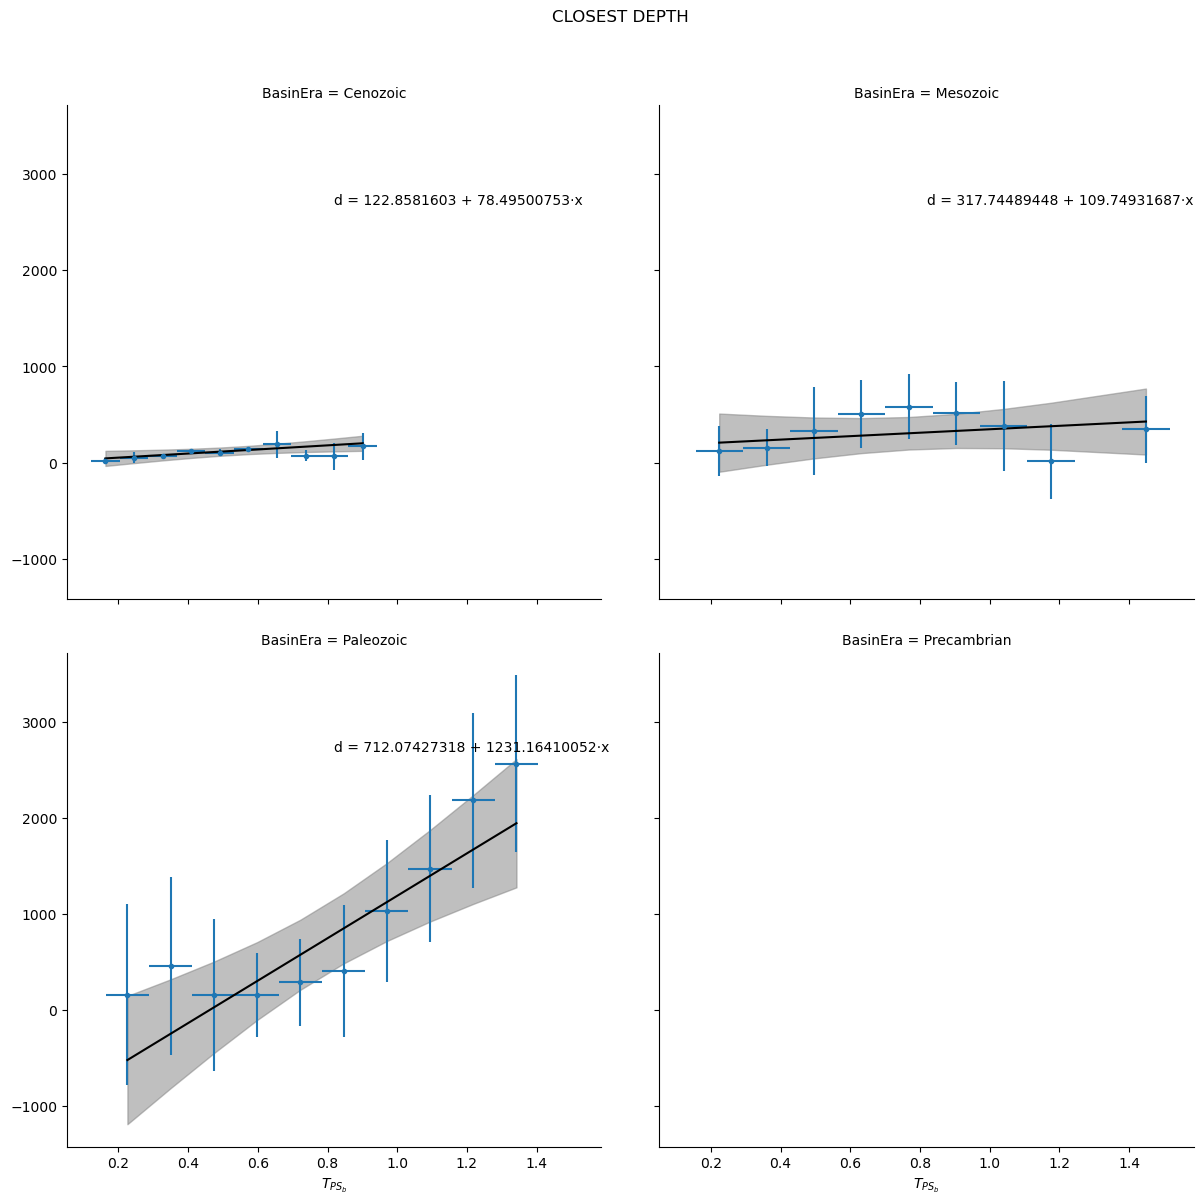

In [12]:
for depth in depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns:
    g = sns.FacetGrid(
        data=seismics,
        col="BasinEra",
        col_order=eras,
        col_wrap=2,
        height=6
    )

    for era in eras[:-1]:  # don't fit Precambrian
        _stations = seismics.loc[seismics["BasinEra"] == era]
        x = _stations.delays
        y = _stations[depth]
        idx = np.isfinite(x) & np.isfinite(y)
        x = x.loc[idx]
        y = y.loc[idx]

        bin_vals, bin_edges, binnumber = stats.binned_statistic(x, y, statistic="median")
        bin_stds, _, _ = stats.binned_statistic(x, y, statistic="std")

        # empty bins return NaN so drop these
        idx = ~np.isfinite(bin_vals)
        bin_vals = np.delete(bin_vals, idx)
        bin_stds = np.delete(bin_stds, idx)

        x = bin_edges[1:] + (bin_edges[1:] - bin_edges[:-1]) / 2  # bin midpoints
        x =  np.delete(x, idx)
        x_err = (bin_edges[1] - bin_edges[0]) / 2
        y = bin_vals
        y_err = bin_stds
        y_err[y_err == 0] = y_err.max()
        p = Polynomial.fit(x, y, w=(1 / y_err) / np.nansum(1 / y_err), deg=1)
        yfit = p(x)
        ci = slope_ci(x, y, yfit)
        g.axes_dict[era].errorbar(x, y, y_err, x_err, fmt=".")
        g.axes_dict[era].plot(x, yfit, color="k")
        g.axes_dict[era].fill_between(x, yfit+ci, yfit-ci, color="grey", alpha=0.5)

        g.axes_dict[era].text(0.5, 0.8, transform=g.axes_dict[era].transAxes, s=f"d = {str(p)}")

    g.axes[2].set_xlabel("$T_{PS_{b}}$")
    g.axes[3].set_xlabel("$T_{PS_{b}}$")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(depth.replace("_", " "))

Higher order polynomials

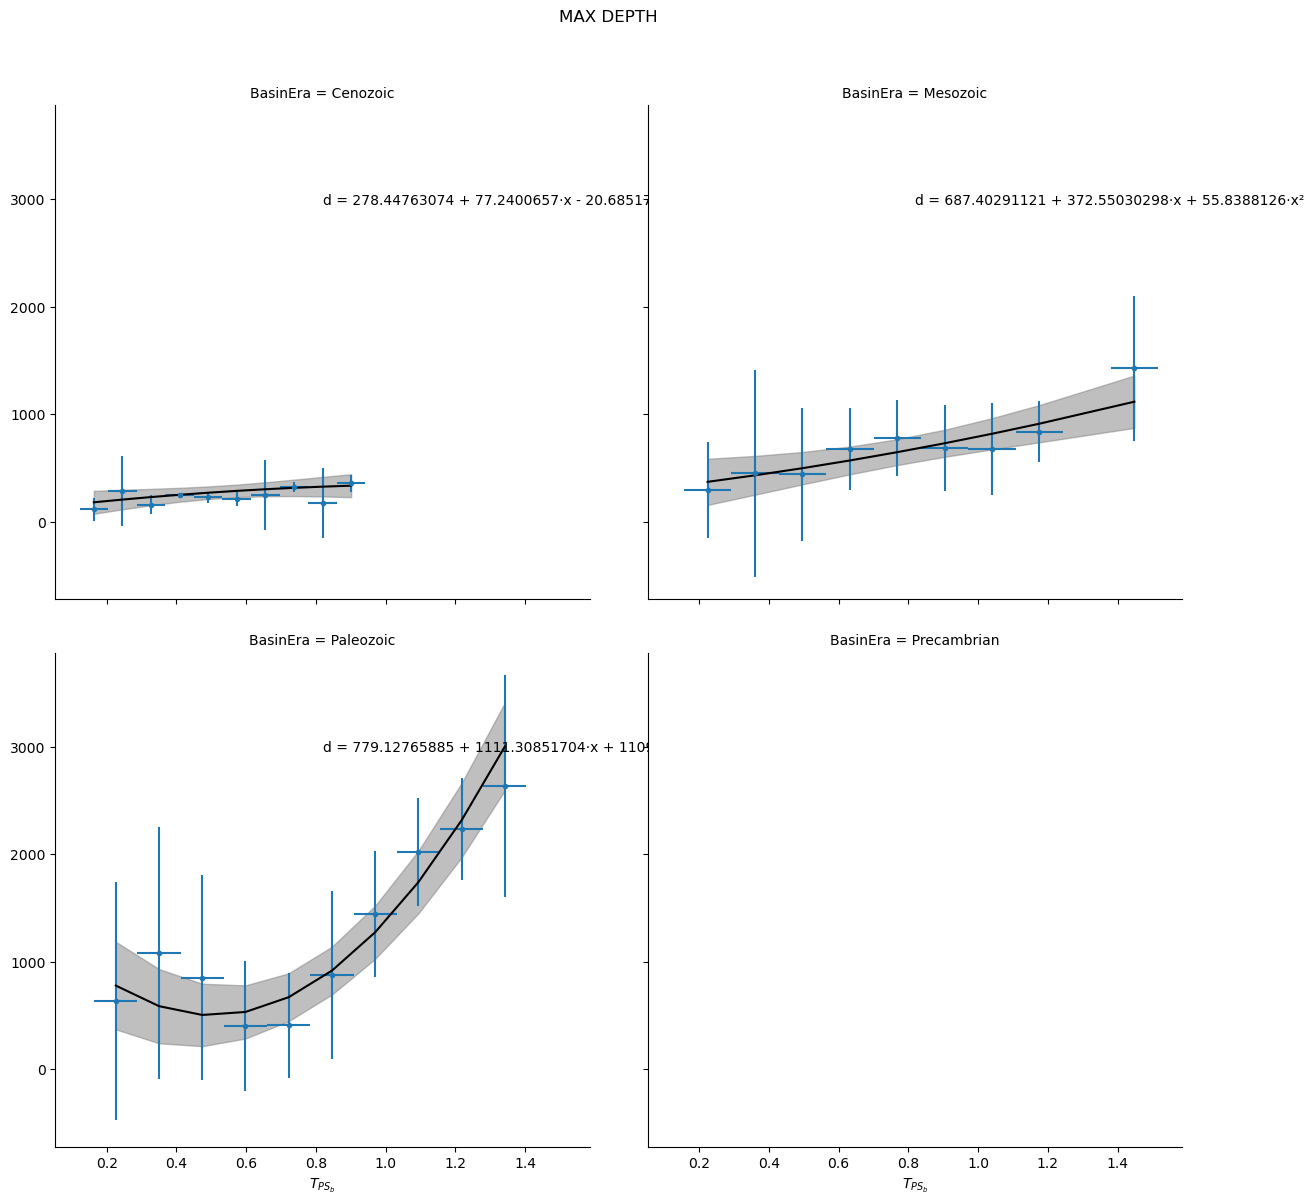

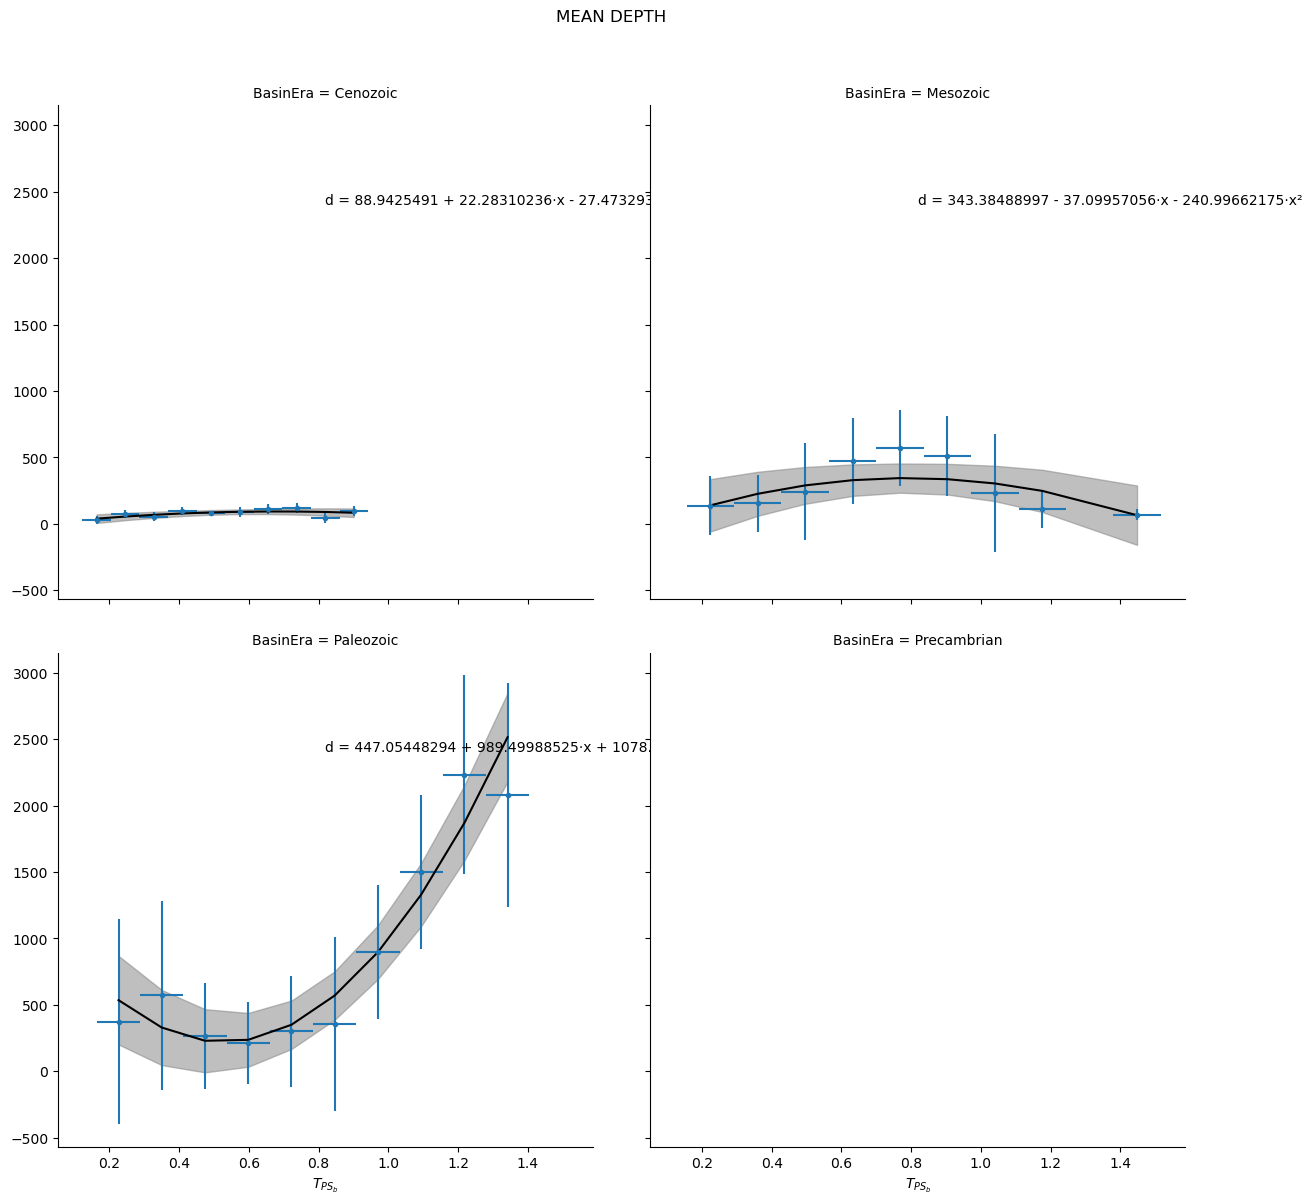

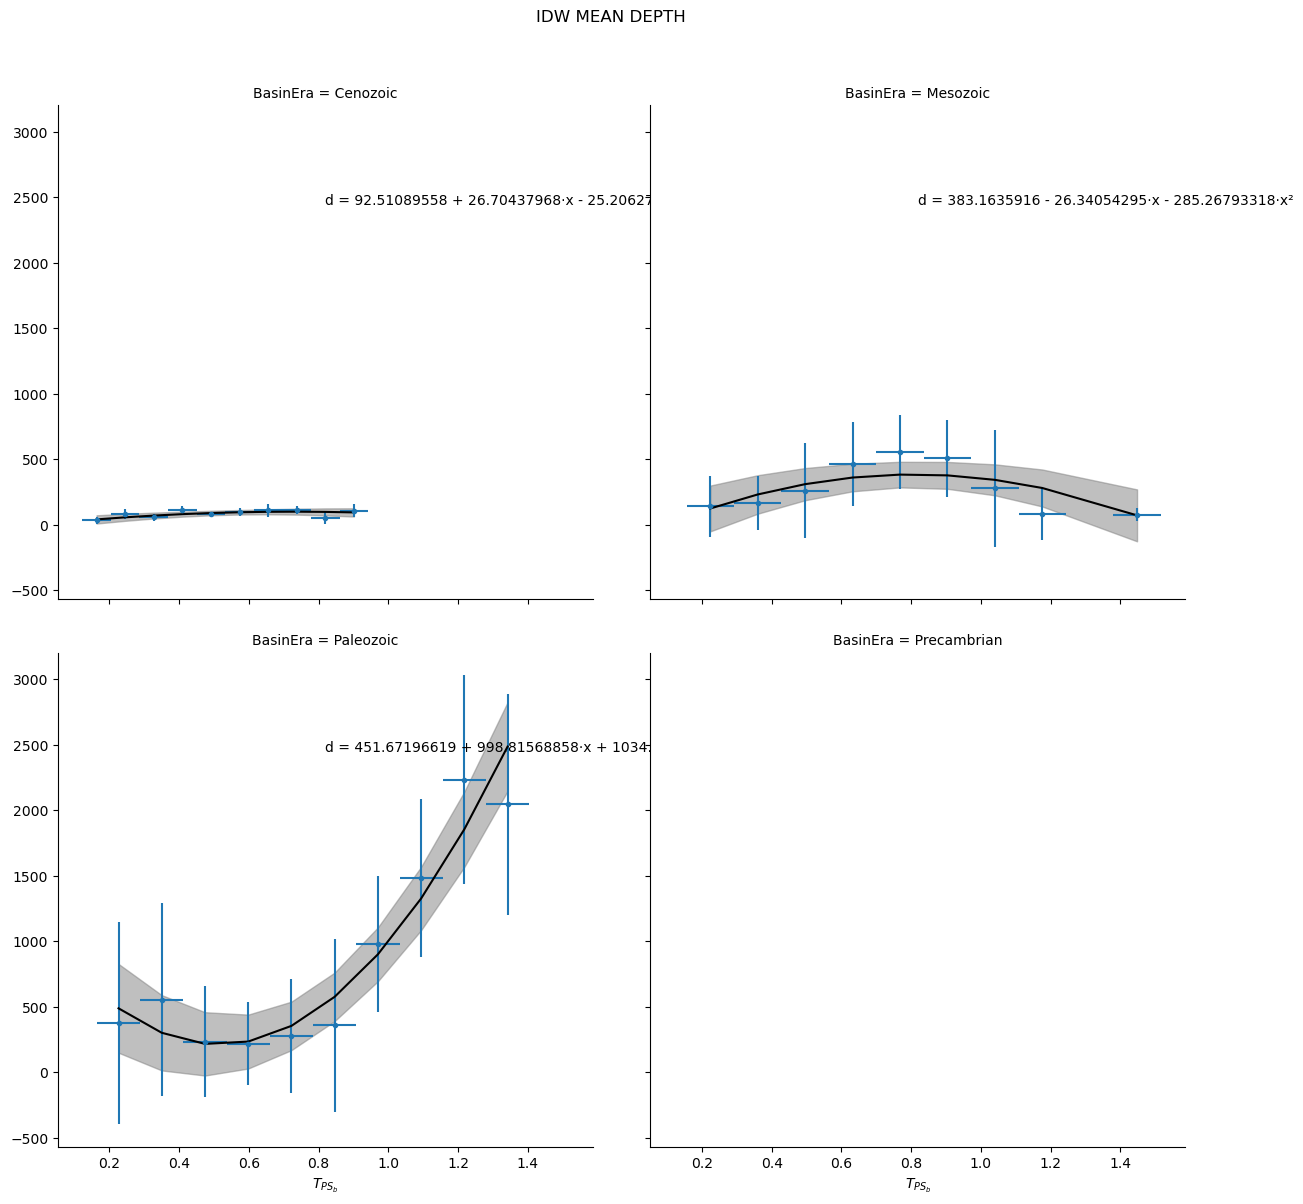

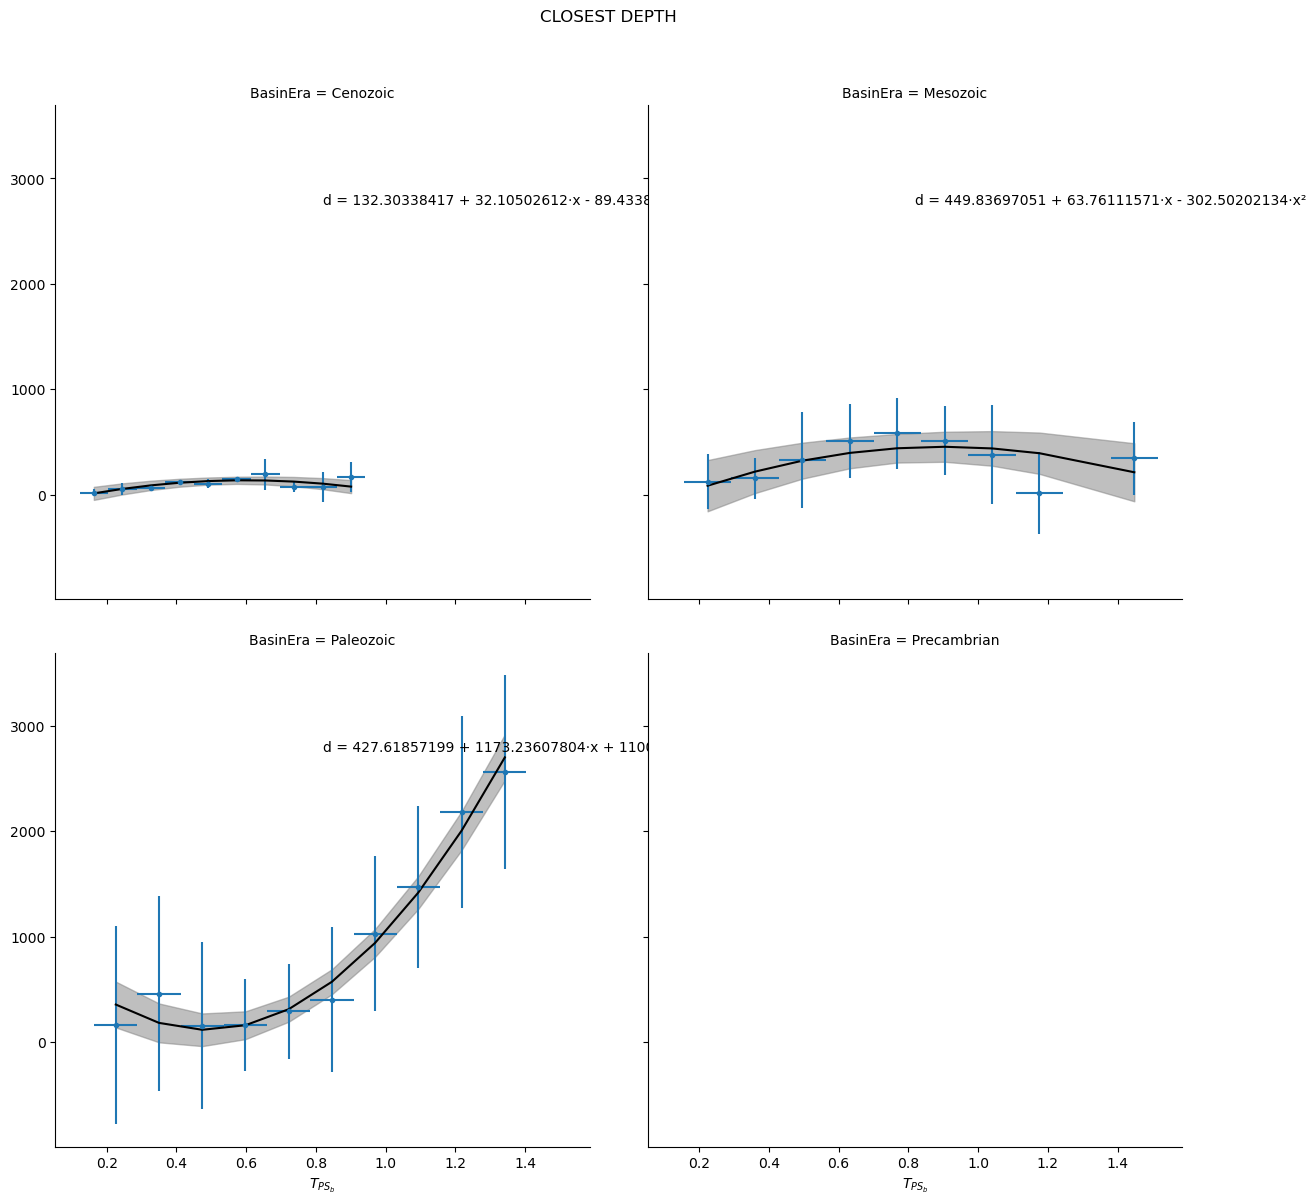

In [15]:
for depth in depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns:
    g = sns.FacetGrid(
        data=seismics, col="BasinEra", col_order=eras, col_wrap=2, height=6
    )

    for era in eras[:-1]:  # don't fit Precambrian
        _stations = seismics.loc[seismics["BasinEra"] == era]
        x = _stations.delays
        y = _stations[depth]
        idx = np.isfinite(x) & np.isfinite(y)
        x = x.loc[idx]
        y = y.loc[idx]

        bin_vals, bin_edges, binnumber = stats.binned_statistic(
            x, y, statistic="median"
        )
        bin_stds, _, _ = stats.binned_statistic(x, y, statistic="std")

        # empty bins return NaN so drop these
        idx = ~np.isfinite(bin_vals)
        bin_vals = np.delete(bin_vals, idx)
        bin_stds = np.delete(bin_stds, idx)

        x = bin_edges[1:] + (bin_edges[1:] - bin_edges[:-1]) / 2  # bin midpoints
        x = np.delete(x, idx)
        x_err = (bin_edges[1] - bin_edges[0]) / 2
        y = bin_vals
        y_err = bin_stds
        y_err[y_err == 0] = y_err.max()
        p = Polynomial.fit(
            x, y, w=(1 / y_err) / np.nansum(1 / y_err), deg=2
        )
        yfit = p(x)
        ci = slope_ci(x, y, yfit)
        g.axes_dict[era].errorbar(x, y, y_err, x_err, fmt=".")
        g.axes_dict[era].plot(x, yfit, color="k")
        g.axes_dict[era].fill_between(x, yfit + ci, yfit - ci, color="grey", alpha=0.5)

        g.axes_dict[era].text(
            0.5,
            0.8,
            transform=g.axes_dict[era].transAxes,
            s=f"d = {str(p)}",
        )

    g.axes[2].set_xlabel("$T_{PS_{b}}$")
    g.axes[3].set_xlabel("$T_{PS_{b}}$")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(depth.replace("_", " "))